# Aplikacja Tomografu
## Paweł Mazurkiewicz 156145
## Filip Michalski 155947

In [3]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import math
import ipywidgets as widgets
from IPython.display import display, clear_output

# Algorytm Bresenhama


In [4]:
def bresenham(x0, y0, x1, y1):
    dx = x1 - x0
    dy = y1 - y0

    xsign = 1 if dx > 0 else -1
    ysign = 1 if dy > 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        xx, xy, yx, yy = xsign, 0, 0, ysign
    else:
        dx, dy = dy, dx
        xx, xy, yx, yy = 0, ysign, xsign, 0

    D = 2 * dy - dx
    y = 0

    for x in range(dx + 1):
        yield x0 + x * xx + y * yx, y0 + x * xy + y * yy
        if D >= 0:
            y += 1
            D -= 2 * dx
        D += 2 * dy
        
def simulate_ray(image, x_e, y_e, x_d, y_d):
    height, width = image.shape
    total = 0

    # Sumujemy wartości pikseli wzdłuż promienia
    for x, y in bresenham(int(round(x_e)), int(round(y_e)), int(round(x_d)), int(round(y_d))):
        if 0 <= x < width and 0 <= y < height:
            total += image[y, x]
    return total

In [9]:
folder_path = "./images"

# Lista plików DICOM
dicom_files = glob.glob(os.path.join(folder_path, "*.dcm"))

# Lista nazw plików (bez ścieżki)
file_names = [os.path.basename(f) for f in dicom_files]

# Dropdown z listą plików
dropdown = widgets.Dropdown(
    options=file_names,
    description='Plik DICOM:',
    disabled=False,
)

# Zmienna globalna na wybraną ścieżkę
selected_file = None

# Funkcja przypisująca ścieżkę
def on_file_selected(change):
    global selected_file
    selected_file = os.path.join(folder_path, change['new'])
    print(f"Wybrano plik: {selected_file}")

# Połączenie dropdown z funkcją
dropdown.observe(on_file_selected, names='value')

# Wyświetlenie dropdowna
display(dropdown)

Dropdown(description='Plik DICOM:', options=('Kropka.dcm', 'CT_ScoutView.dcm', 'SADDLE_PE.dcm', 'CT_ScoutView-…

Wybrano plik: ./images/CT_ScoutView.dcm


In [26]:
ds = pydicom.dcmread(selected_file)
pixel_array = ds.pixel_array
normalized = ((pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array)) * 255).astype(np.uint8)

height, width = normalized.shape
center_x, center_y = width / 2, height / 2
R = math.hypot(width, height)

def draw_rays(angle_deg=90, num_emit=100, span=500):
    plt.figure(figsize=(6,6))
    plt.imshow(normalized, cmap='gray')
    plt.title(f"Promienie | Kąt: {angle_deg}° | Emitery: {num_emit} | Span: {span}")
    
    theta = math.radians(angle_deg)

    # Centralne punkty dla emiterów i detektorów (po przeciwnych stronach)
    x_center_emiter = center_x + R * math.cos(theta)
    y_center_emiter = center_y + R * math.sin(theta)
    x_center_detector = center_x - R * math.cos(theta)
    y_center_detector = center_y - R * math.sin(theta)

    # Kierunki linii emiterów i detektorów (prostopadle do promienia)
    dir_x = -math.sin(theta)
    dir_y = math.cos(theta)

    for i in range(num_emit):
        s = -span/2 + i * (span / (num_emit - 1))
        x_e = x_center_emiter + s * dir_x
        y_e = y_center_emiter + s * dir_y
        x_d = x_center_detector + s * dir_x
        y_d = y_center_detector + s * dir_y

        # Rysowanie promieni
        plt.plot([x_e, x_d], [y_e, y_d], color='red', alpha=0.3)

    plt.axis("off")
    plt.gca().invert_yaxis()
    plt.show()

# Interaktywny widget
widgets.interact(
    draw_rays,
    angle_deg=widgets.IntSlider(min=0, max=179, step=1, value=90, description='Kąt (°)'),
    num_emit=widgets.IntSlider(min=10, max=500, step=10, value=100, description='Liczba emiterów'),
    span=widgets.FloatSlider(min=50, max=1000, step=10, value=500, description='Span [px]')
);


interactive(children=(IntSlider(value=90, description='Kąt (°)', max=179), IntSlider(value=100, description='L…

(1024, 880)


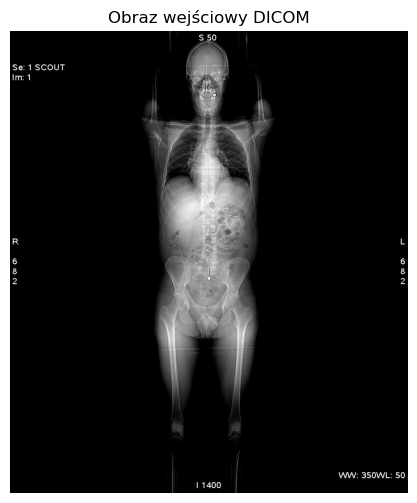

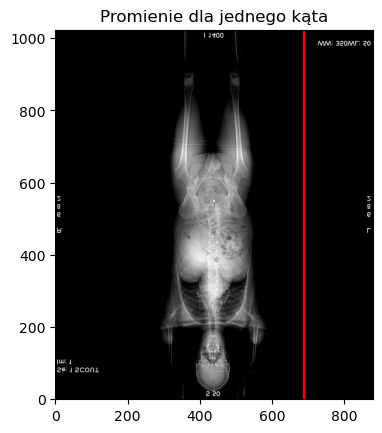

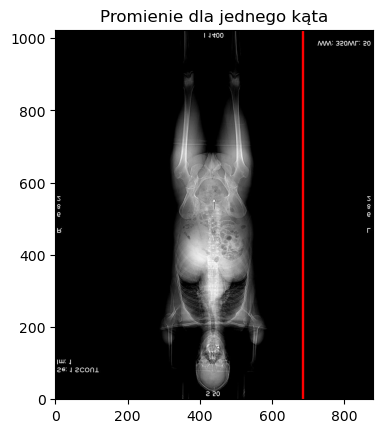

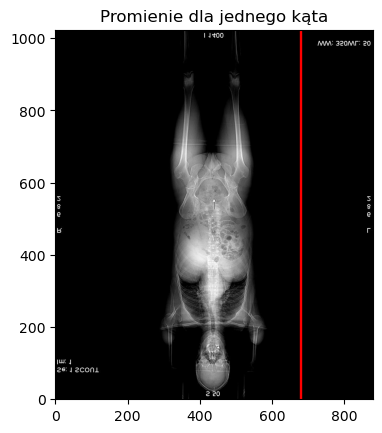

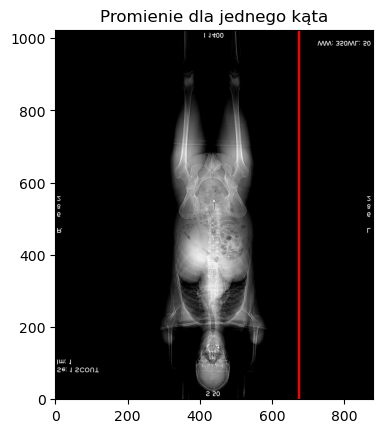

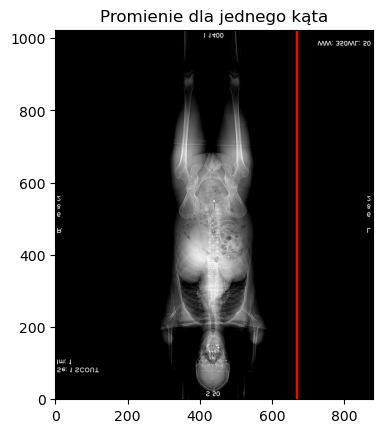

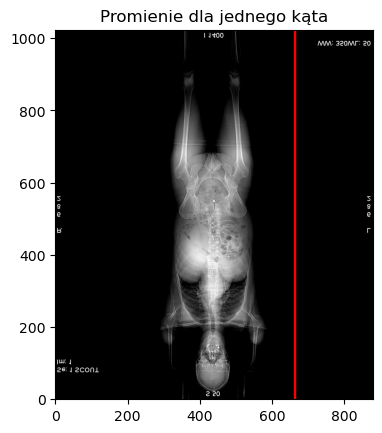

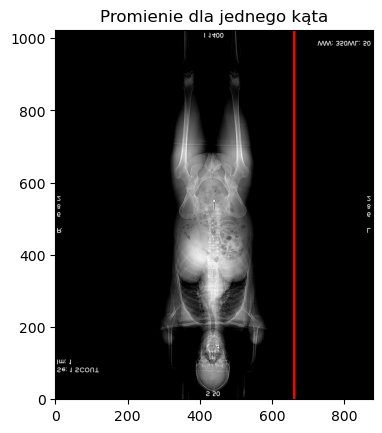

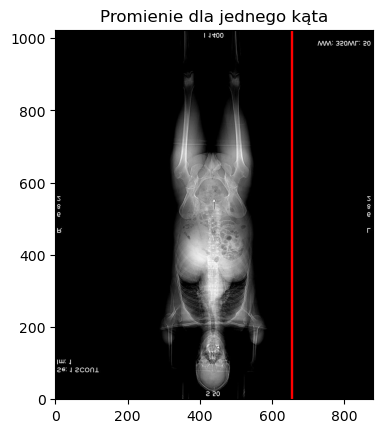

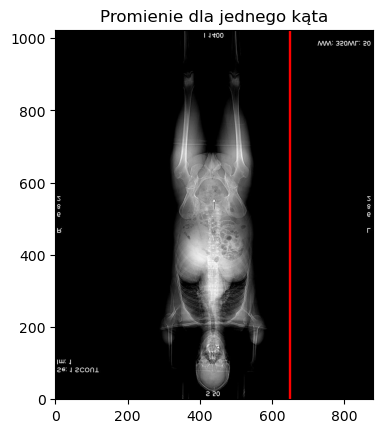

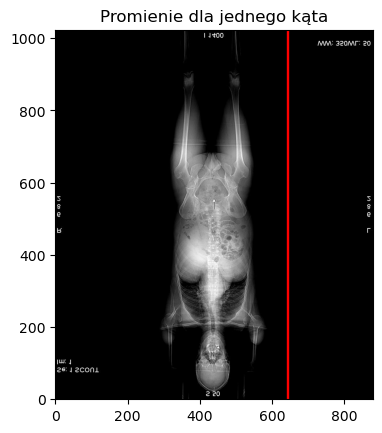

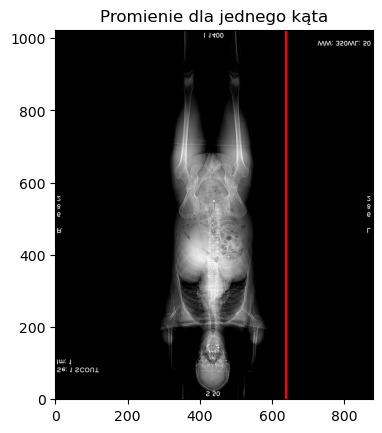

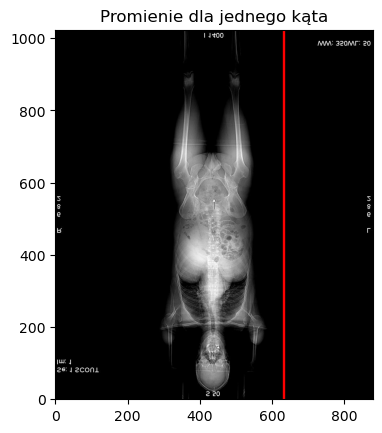

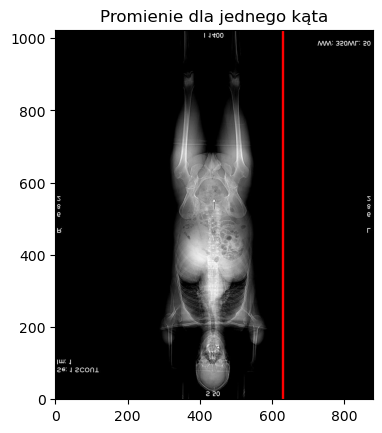

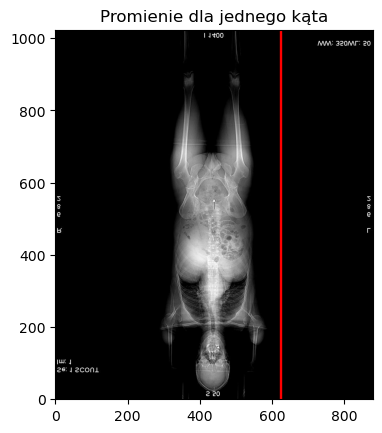

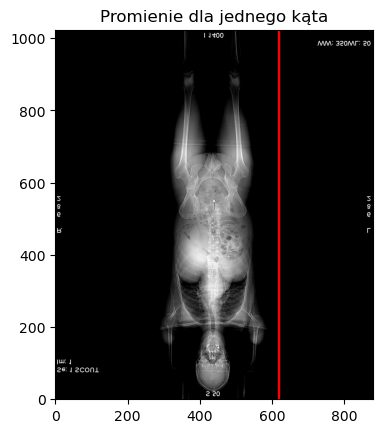

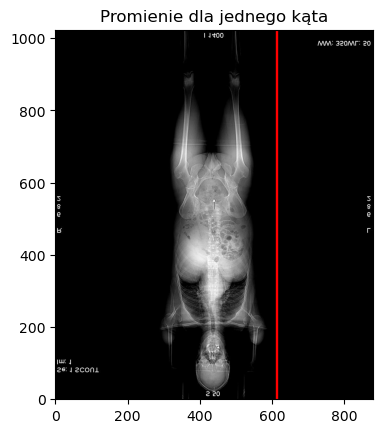

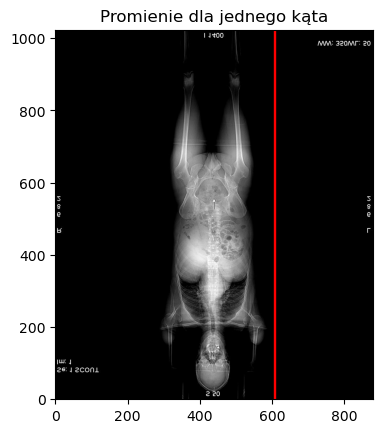

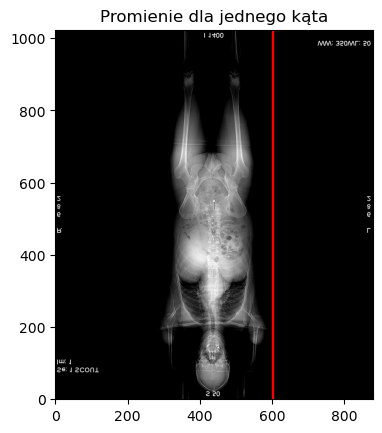

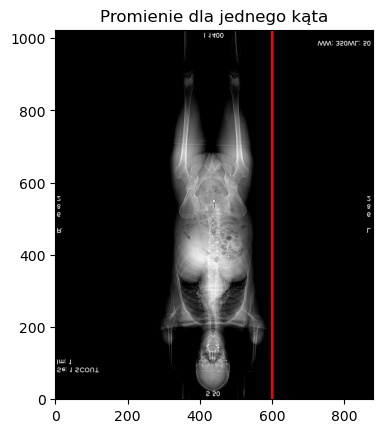

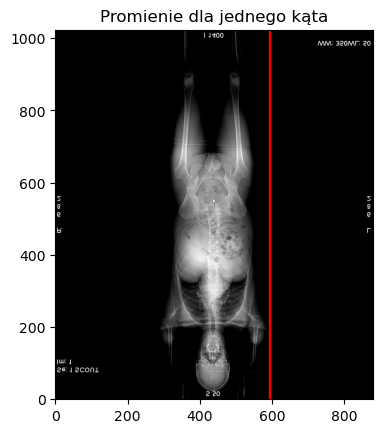

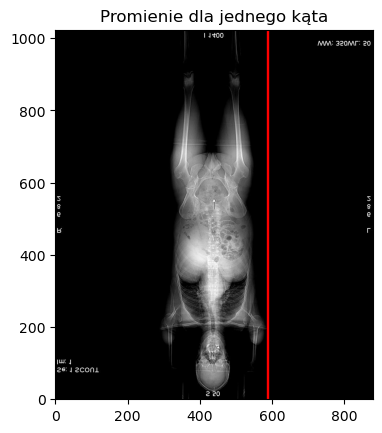

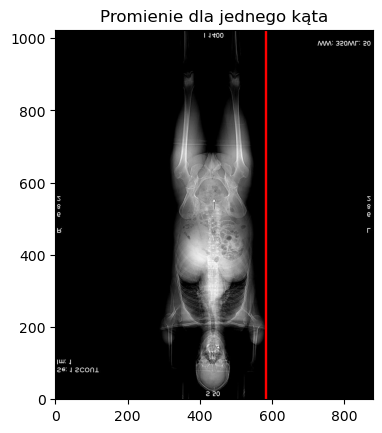

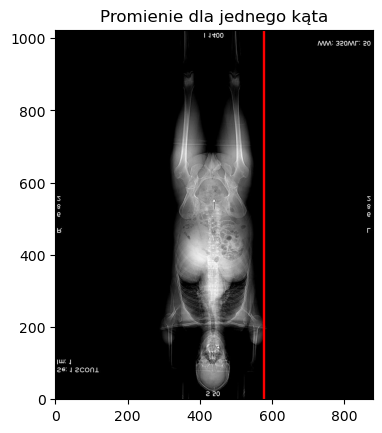

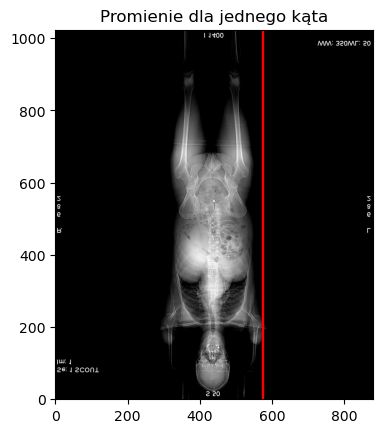

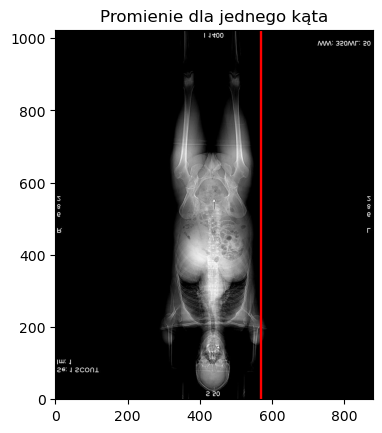

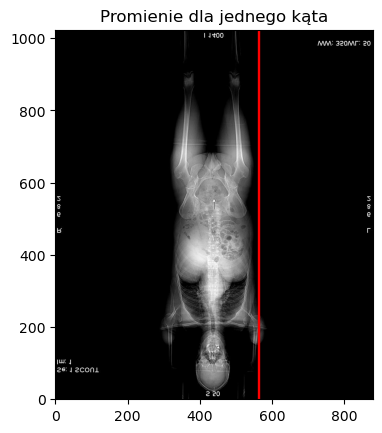

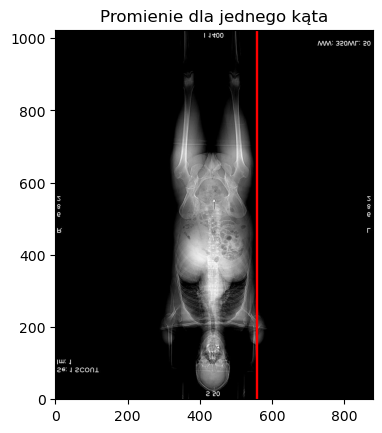

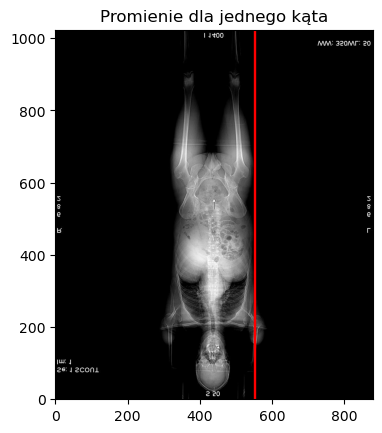

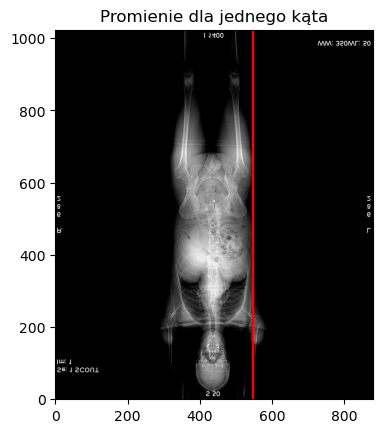

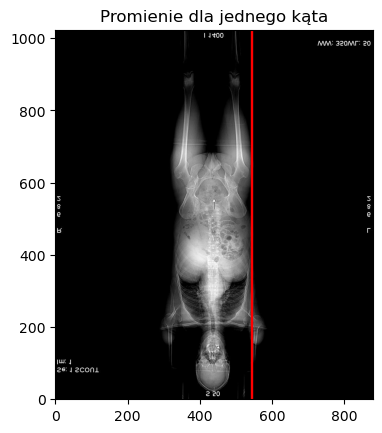

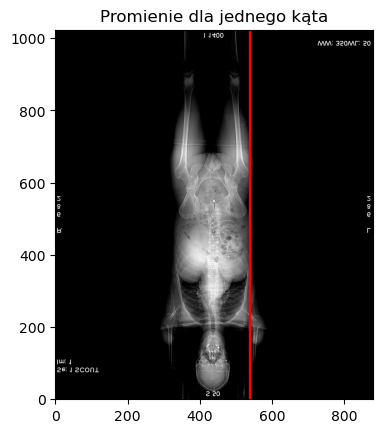

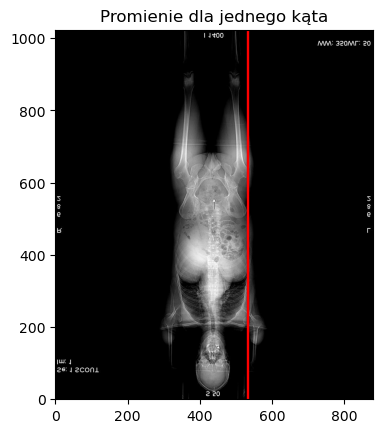

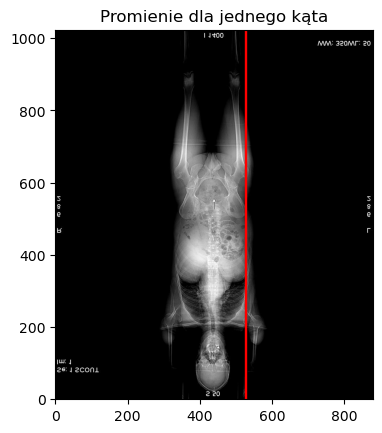

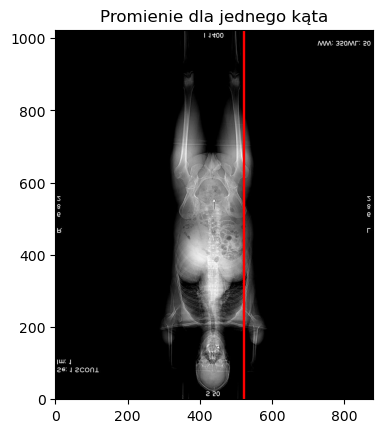

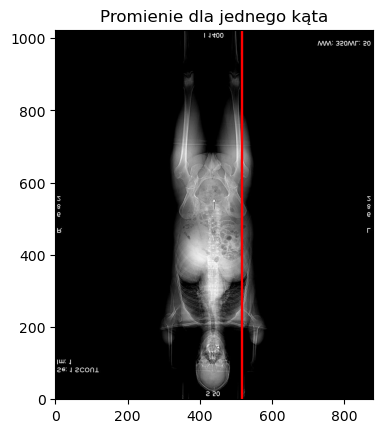

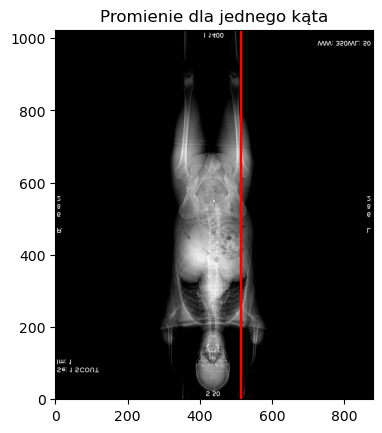

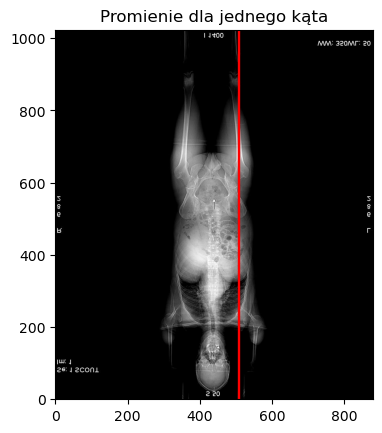

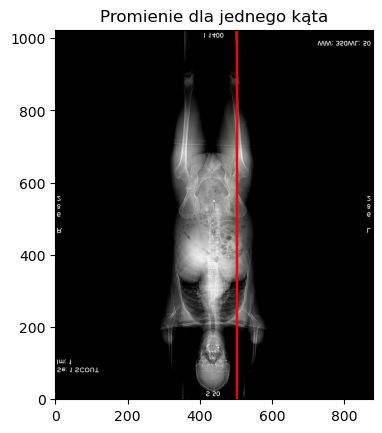

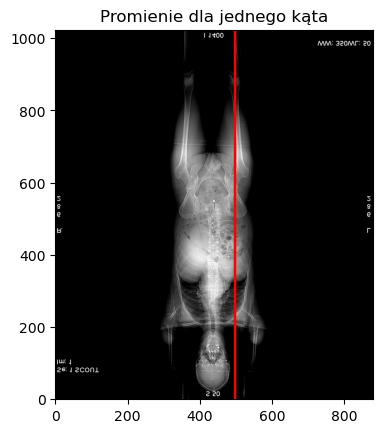

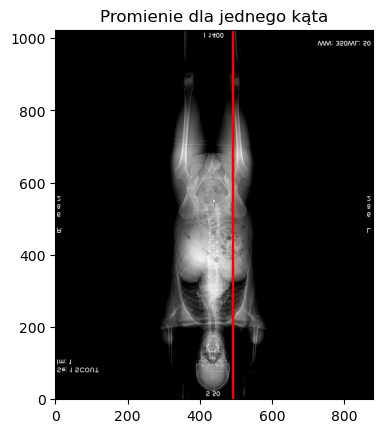

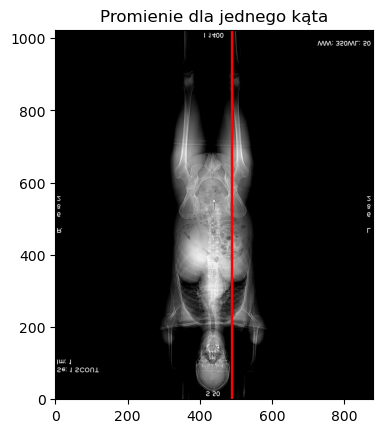

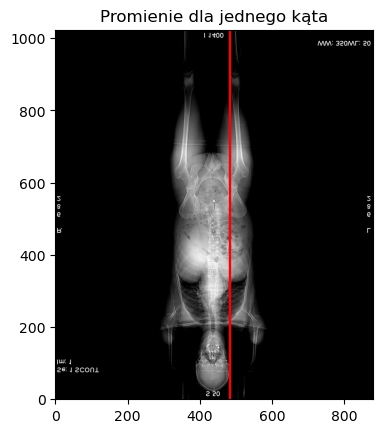

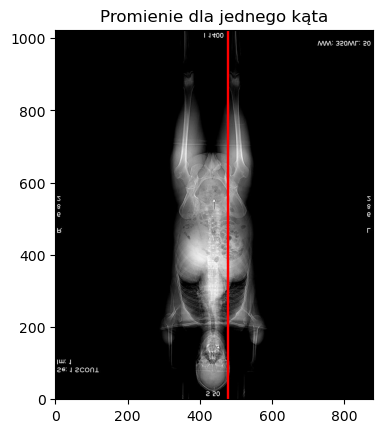

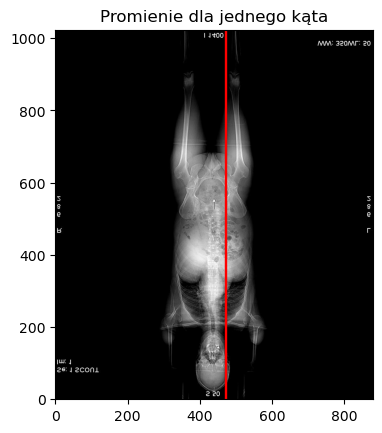

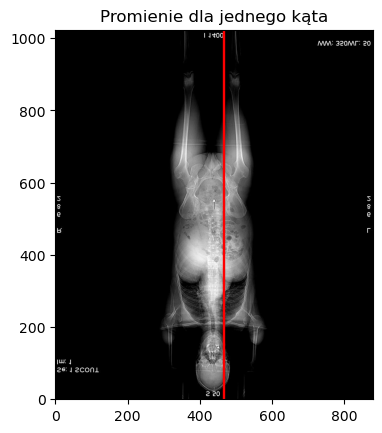

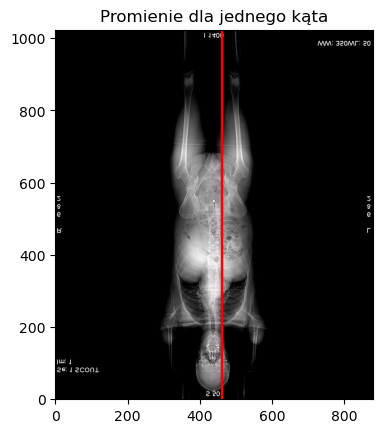

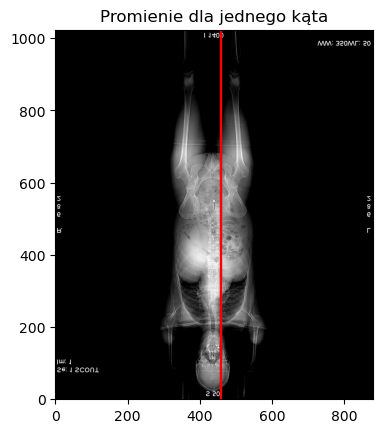

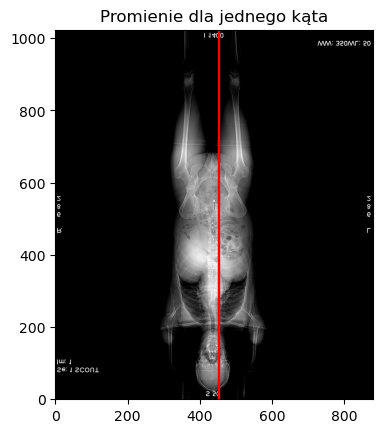

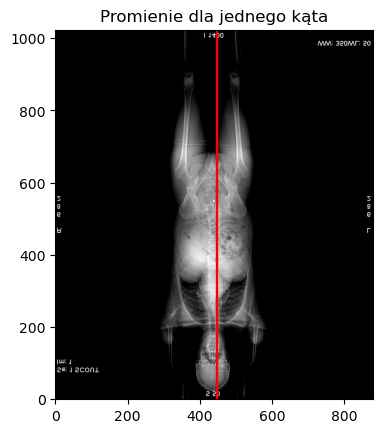

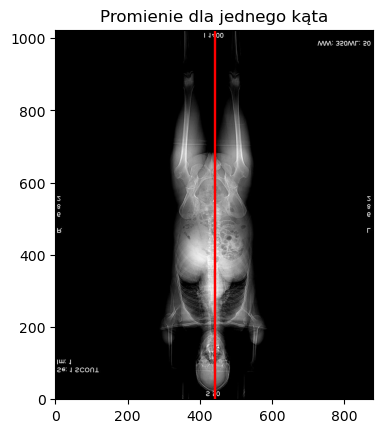

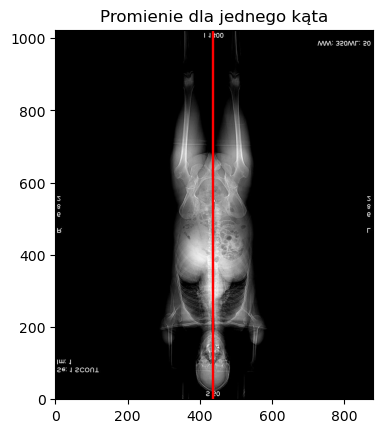

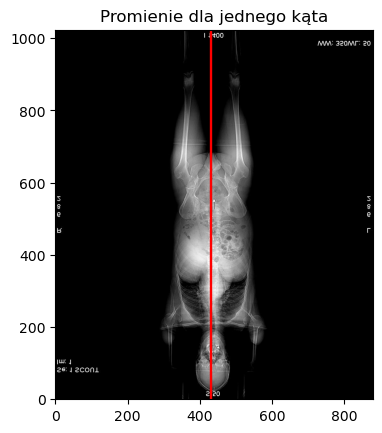

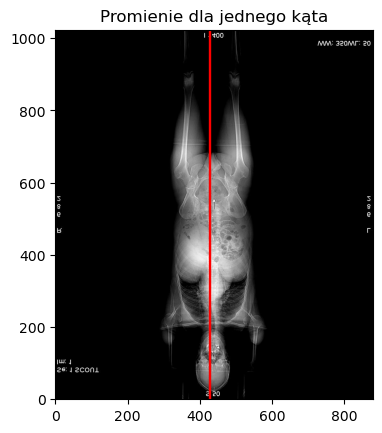

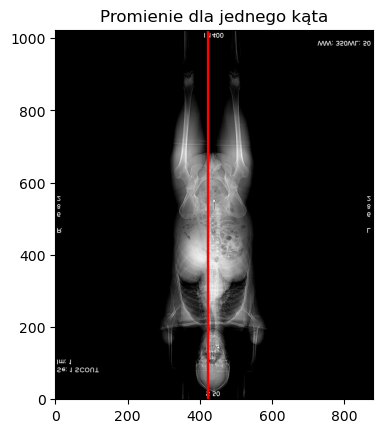

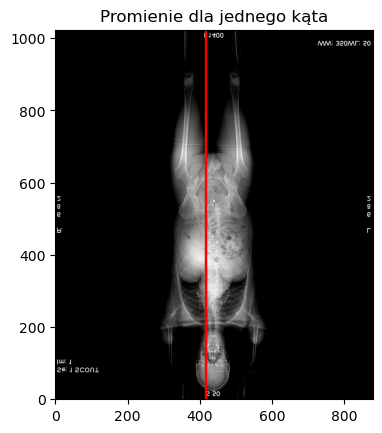

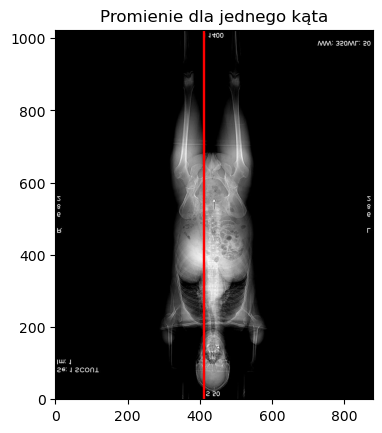

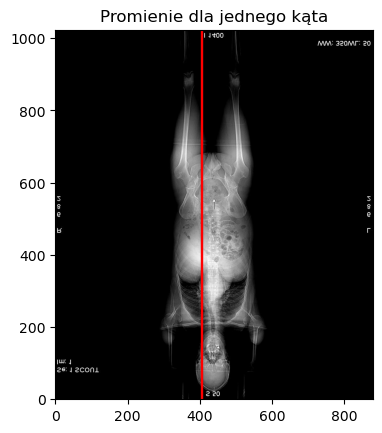

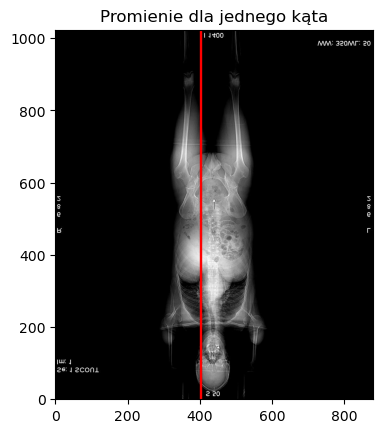

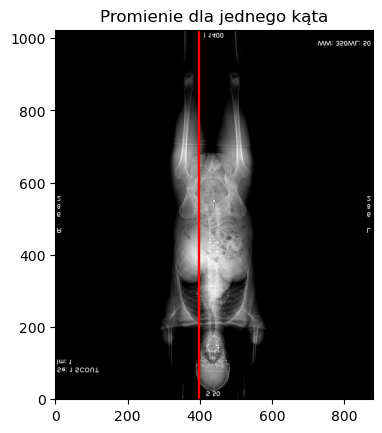

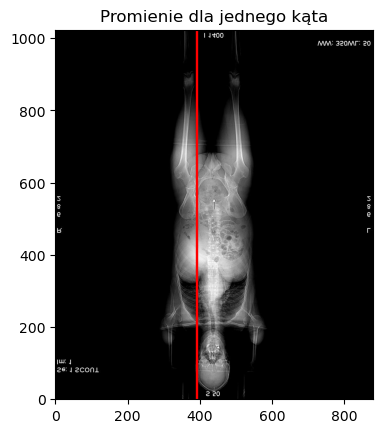

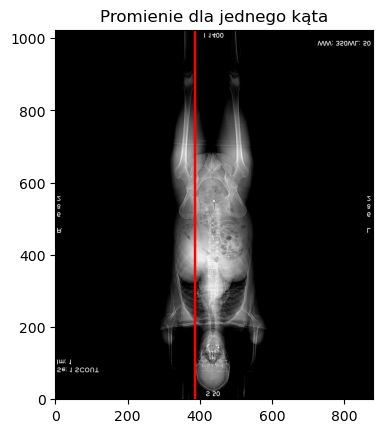

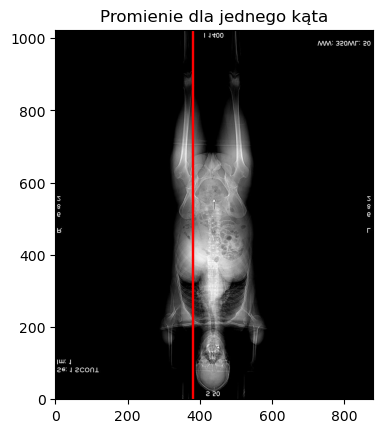

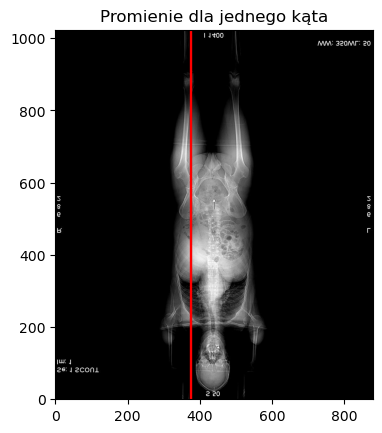

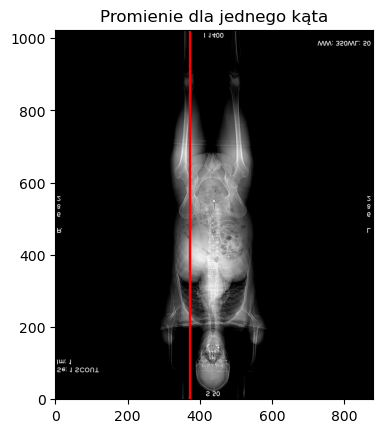

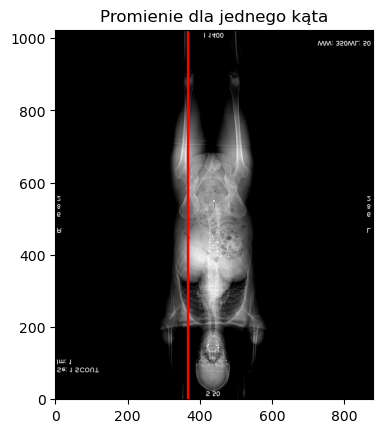

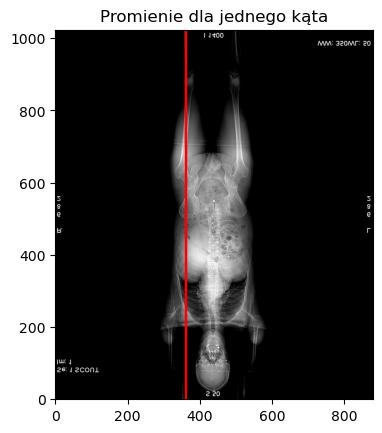

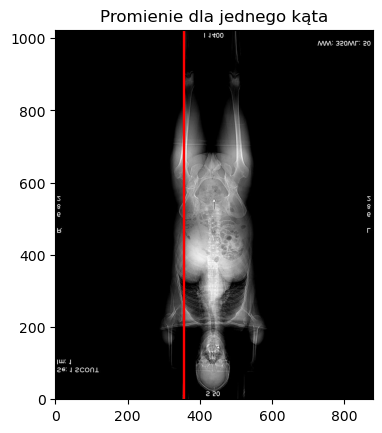

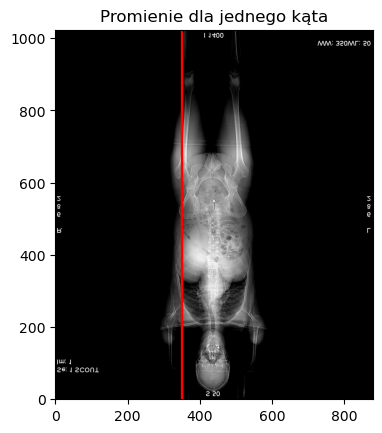

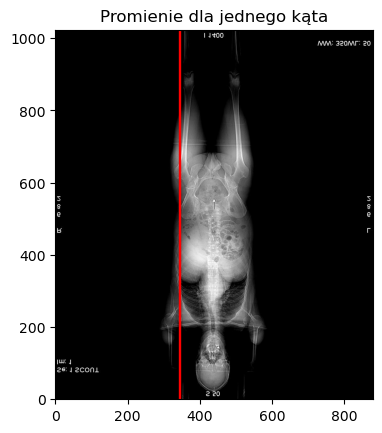

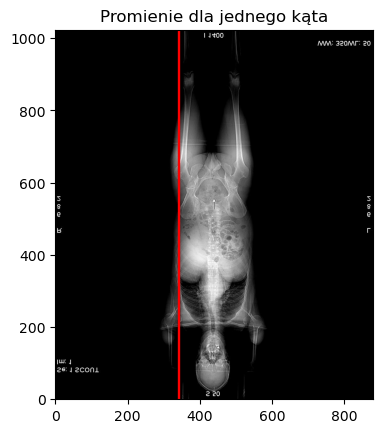

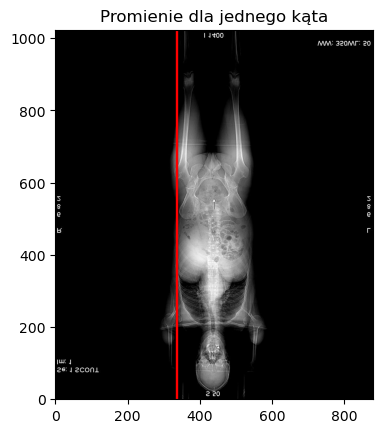

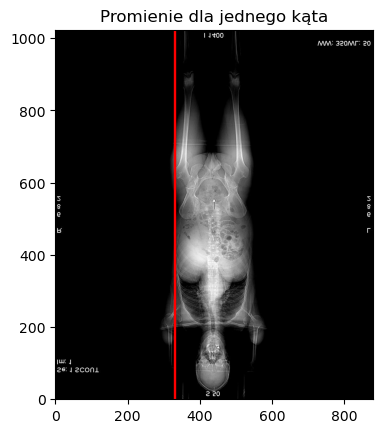

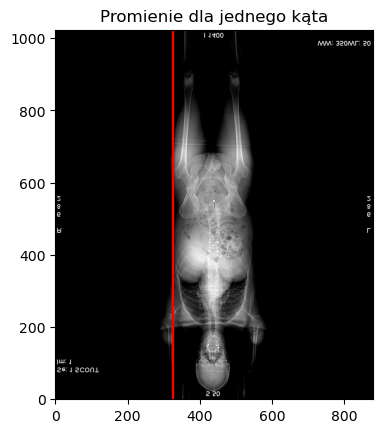

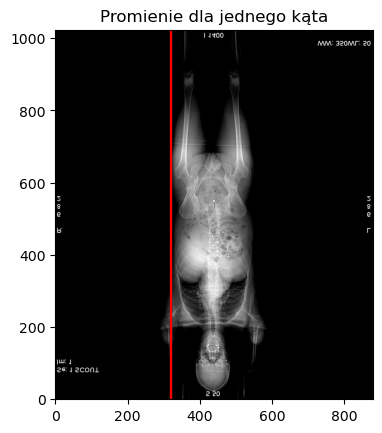

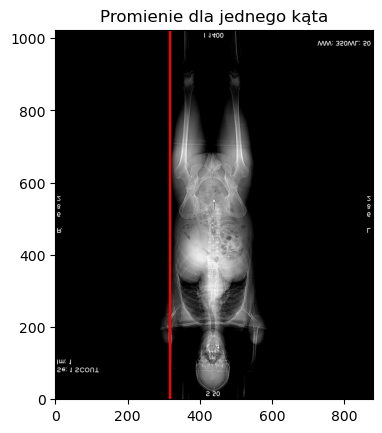

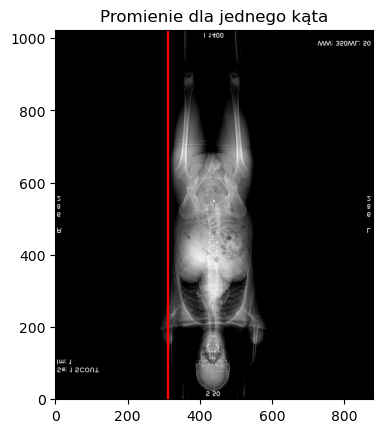

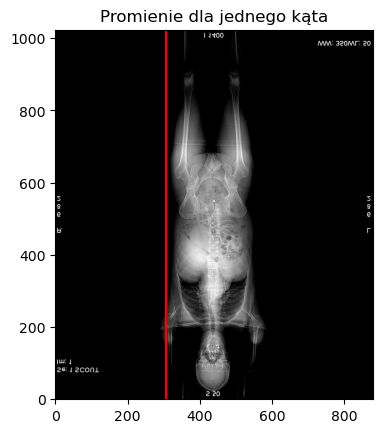

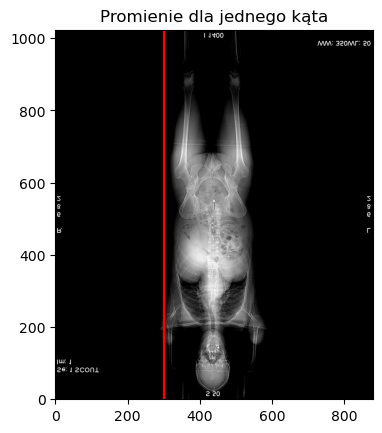

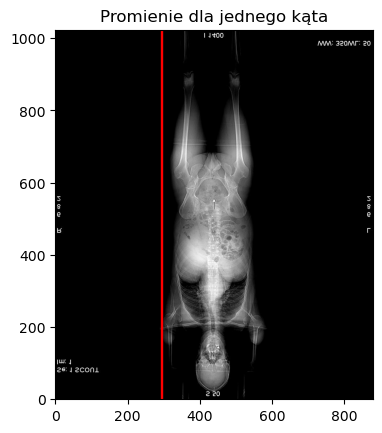

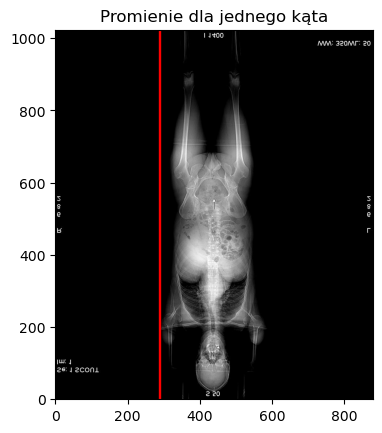

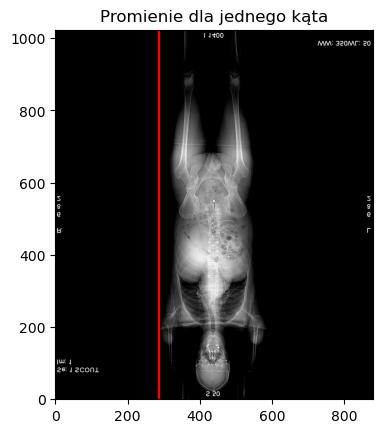

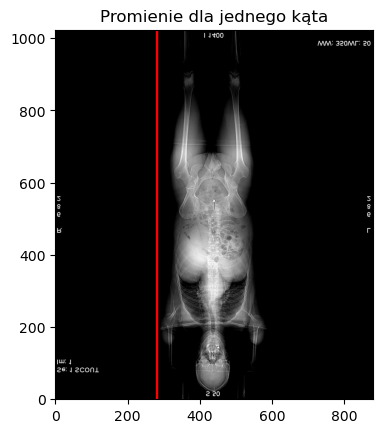

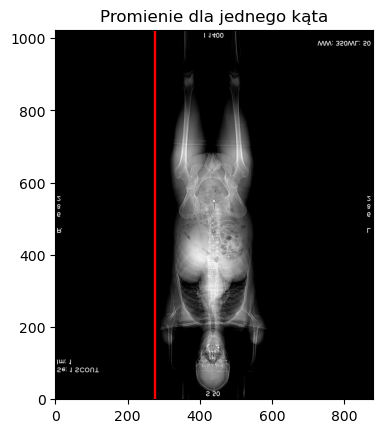

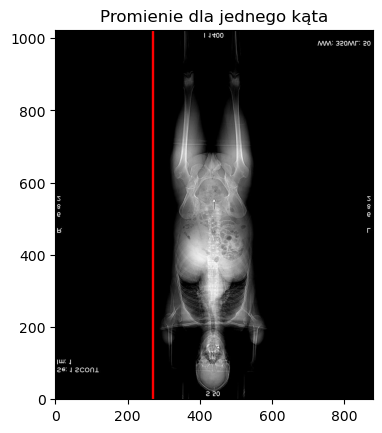

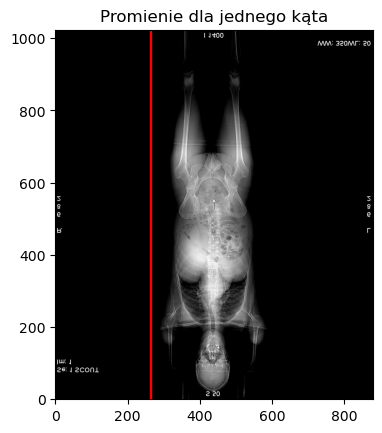

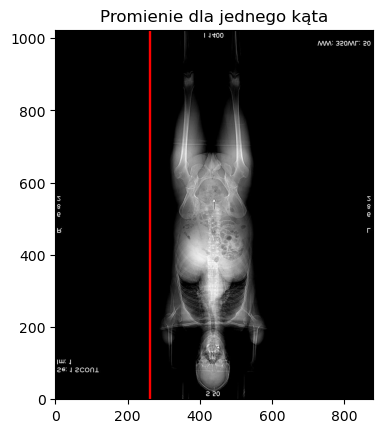

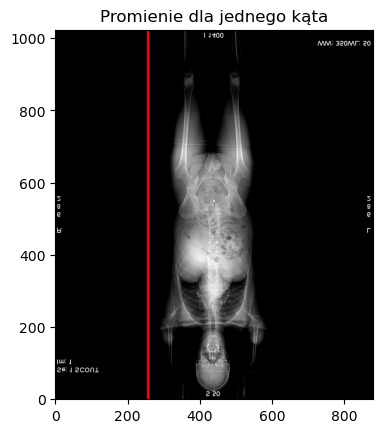

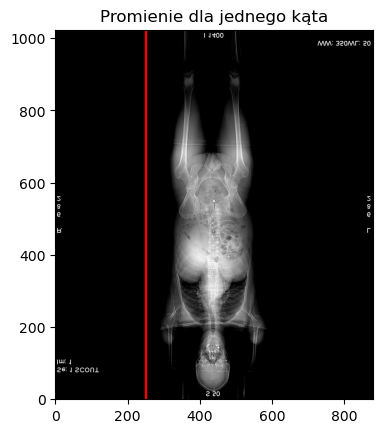

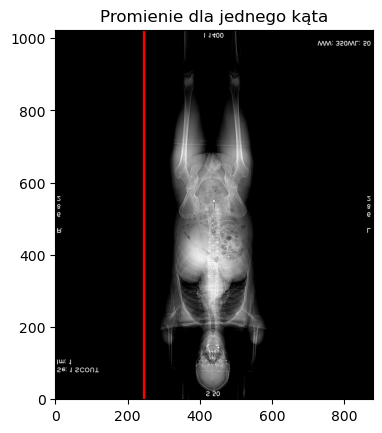

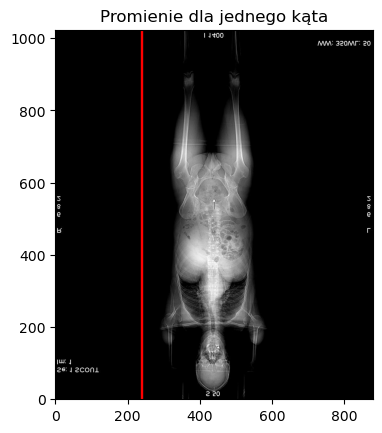

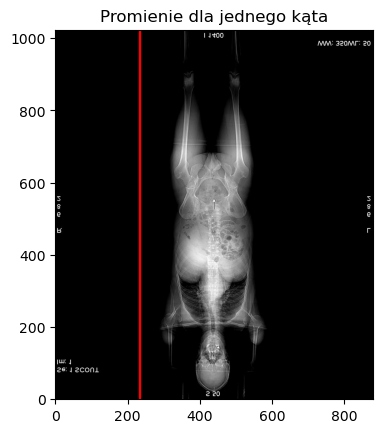

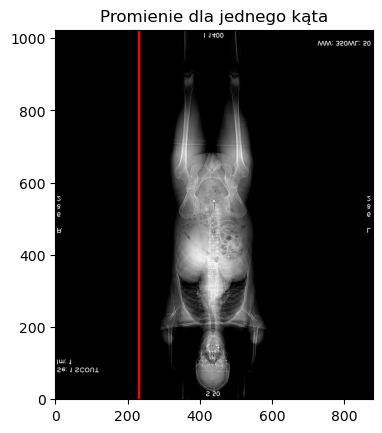

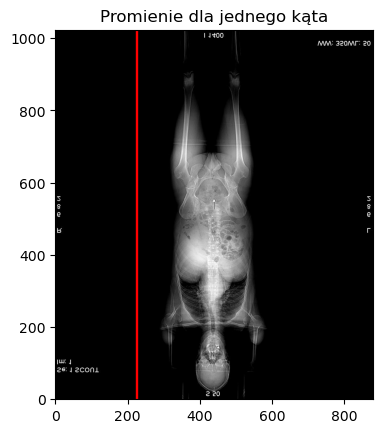

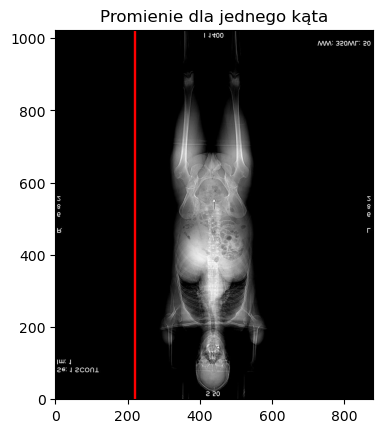

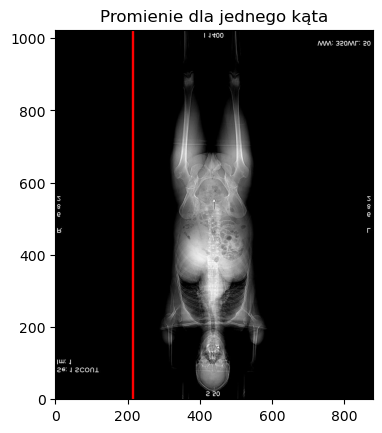

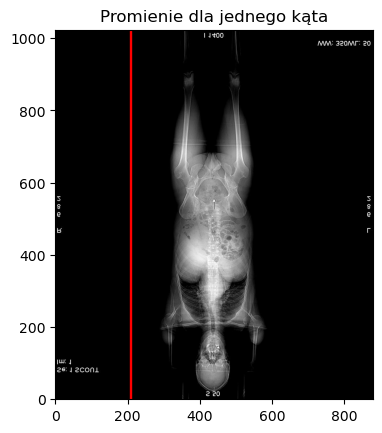

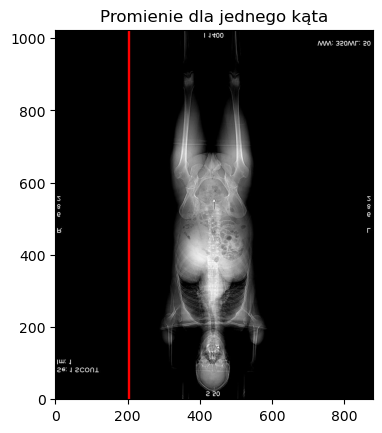

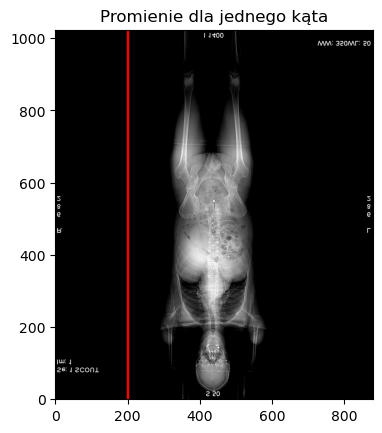

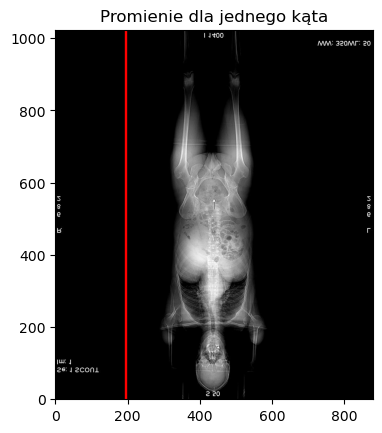

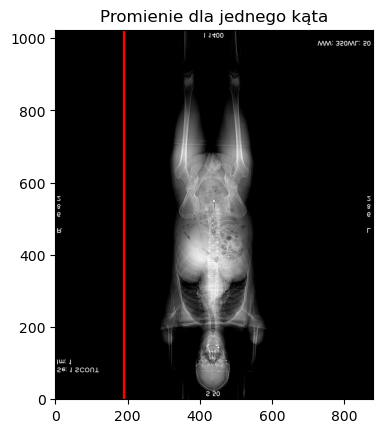

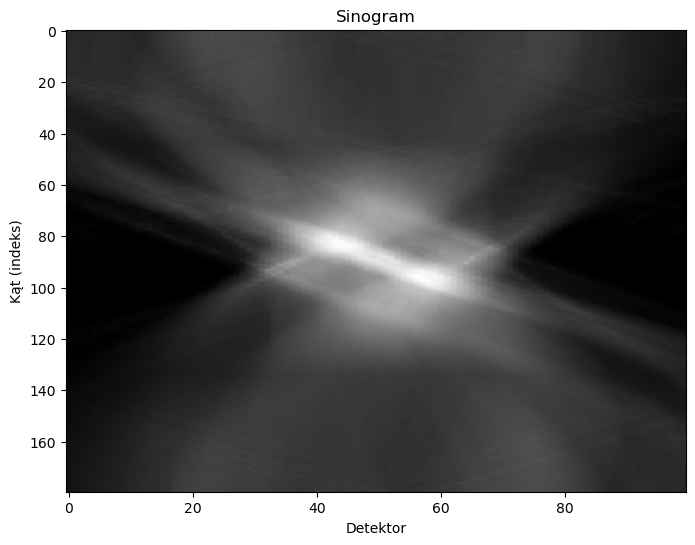

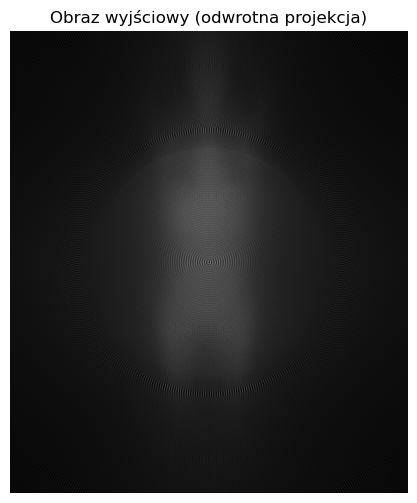

In [25]:


delta_alpha = 1
num_angles = int(180 / delta_alpha)
num_emiters = 100
num_detectors = 100

emitter_span = 500
detector_span = 500


# Wczytanie i normalizacja obrazu DICOM
ds = pydicom.dcmread(selected_file)
pixel_array = ds.pixel_array
normalized = ((pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array)) *255).astype(np.uint8)
print(normalized.shape)
# Wyświetlenie obrazu wejściowego
plt.figure(figsize=(6,6))
plt.imshow(normalized, cmap='gray')
plt.title("Obraz wejściowy DICOM")
plt.axis("off")
plt.show()

height, width = normalized.shape
emiter_length = math.sqrt( pow(height, 2) + pow(width, 2) ) 
detector_length = math.sqrt( pow(height, 2) + pow(width, 2) )  # rozpiętość układu detektorów (w pikselach)

center_x, center_y = width / 2, height / 2

# Ustalamy promień okręgu symulacyjnego tak, aby obejmował cały obraz (tu: przekątna/2 plus ewentualnie margines)
R = math.hypot(width, height)

# Inicjujemy macierz sinogramu: każdy wiersz odpowiada jednemu kątowi,
# a każda kolumna – pozycji jednego detektora
sinogram = np.zeros((num_angles, num_detectors))
#print(sinogram, sinogram.shape)
# Rekonstrukcja przez odwrotną projekcję - obraz wyjściowy
reconstruction = np.zeros_like(normalized, dtype=np.float64)
#print(reconstruction, reconstruction.shape)

# Przetwarzamy każdy kąt
for angle_idx, alpha in enumerate(np.linspace(1, 180, num_angles)):
    #theta - kąt alpha w radianach
    theta = math.radians(alpha)
    
    # Pozycja emitera - na okręgu wokół obrazu
    x_center_emiter = center_x + R * math.cos(theta)
    y_center_emiter = center_y + R * math.sin(theta)

    # Pozycja centralna detektorów (przeciwna strona)
    x_center_detector = center_x - R * math.cos(theta)
    y_center_detector = center_y - R * math.sin(theta)


    # Kierunek układu detektorów: prostopadły do promienia (wektor jednostkowy)
    det_dir_x = -math.sin(theta)
    det_dir_y = math.cos(theta)

    emiter_dir_x = -math.sin(theta)
    emiter_dir_y = math.cos(theta)

    # Przechodzimy po każdym detektorze
    for det_idx in range(num_detectors):
        
        # Obliczamy przesunięcie wzdłuż linii emiterów
        # s = -emiter_length/2 + det_idx * (emiter_length/(num_emiters-1))
        s = -emitter_span/2 + det_idx * (emitter_span / (num_emiters - 1))
        # pozycja danego emitera
        x_e = x_center_emiter + s * emiter_dir_x
        y_e = y_center_emiter + s * emiter_dir_y

        # Obliczamy przesunięcie wzdłuż linii detektorów
        # Pozycja od -l/2 do +l/2
        # s = -detector_length/2 + det_idx * (detector_length/(num_detectors-1))
        s = -detector_span/2 + det_idx * (detector_span / (num_detectors - 1))
        # Pozycja danego detektora
        x_d = x_center_detector + s * det_dir_x
        y_d = y_center_detector + s * det_dir_y

        # Symulujemy promień dla danej pary emiter-detektor
        ray_value = simulate_ray(normalized, x_e, y_e, x_d, y_d)
        sinogram[angle_idx, det_idx] = ray_value
        if angle_idx == 89:  # dla jednego kąta
            for i in range(0, num_detectors, 20):  # co 20-ty promień, żeby nie zasypać
                plt.plot([x_e, x_d], [y_e, y_d], color='red')

            plt.imshow(normalized, cmap='gray')
            plt.title("Promienie dla jednego kąta")
            plt.gca().invert_yaxis()
            plt.show()


        # Odwrotna projekcja (prostą metodą dodajemy wartość promienia do pikseli, które promień przecina)
        for x, y in bresenham(int(round(x_e)), int(round(y_e)), int(round(x_d)), int(round(y_d))):
            if 0 <= x < width and 0 <= y < height:
                reconstruction[y, x] += ray_value

# Normalizacja sinogramu do zakresu 0-255 dla wizualizacji
sinogram_norm = ((sinogram - sinogram.min()) / (sinogram.max() - sinogram.min()) * 255).astype(np.uint8)
plt.figure(figsize=(8,6))
plt.imshow(sinogram_norm, cmap='gray', aspect='auto')
plt.title("Sinogram")
plt.xlabel("Detektor")
plt.ylabel("Kąt (indeks)")
plt.show()

# Normalizacja rekonstrukcji
reconstruction_norm = ((reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min()) * 255).astype(np.uint8)
plt.figure(figsize=(6,6))
plt.imshow(reconstruction_norm, cmap='gray')
plt.title("Obraz wyjściowy (odwrotna projekcja)")
plt.axis("off")
plt.show()